# Lesion segmentation in MRI Scans for Multiple Sclerosis disease

**Author & Credentials**

Author: *inż. Witold Synowiec*
Thesis supervisor: *dr. inż. Robert Kurjata*
University: Warsaw *University of Technology*
Faculty: *Faculty of Electronics and Information Technology*

## Introduction

The idea for the tool is to accelerate diagnosis via automizing the initial analysis for Multiple Sclerosis.

Multiple Sclerosis (MS) is a chronic disease affecting central nervous system, more specifically the myelin tissue surrounding nerve fibers. The outcome of the loss in the insulation that is preventing certain nerves to conduct properly electric impulses from the brain. From there on the disease may manifest in wide range of ways, muting affected person, preventing them from walking, holding things firm in their arms, triggering pain attacks and many more. Not treated properly or not diagnosed early enough, the disease may cause serious disability. The only way to make a diagnosis early, apart from observing relapses are the brain lesions seen in MRI scan. In fact, certain combination of this two mentioned measures, are used by most common used McDonald criteria for diagnosis of MS. For the reason of making a halt to disease progression early the tool to automate segmentation of lesions is being proposed. The tool is based on Convolutional Neural Network, which is trained for segmenting those lesions.

## The Dataset early processing

The dataset is stored in compressed nifti files (.nii.gz) which need to be unpacked. What's more the images are stored in different directories, which invokes necessity for some initial processing. The method used for this cause are implemented in FilesHelpers/FilesHelper.py. These are not smart methods, as the sources of data may be stored differently, so it's implemented for authors usage only.

What is important is a fact, that for training there need to be folders, one that stores slices from image as one channel 2D arrays in .npy files each slices named a number for example "452.npy". Similarly, the masks must be stored in separate folder each one channel slice named by number and _mask added to the end of the name for example "452_mask.npy". The connection between slice and mask is given by name number.

The method initiate_dataset() is making just that for authors dataset.

In [3]:
from FilesHelpers import FilesHelper
FilesHelper.initiate_dataset()

Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii

## Performing the Loader

## Performing The Training

In [1]:
import torch
print('Pytorch CUDA Version is', torch.version.cuda)
print('Is CUDA supported by system:', torch.cuda.is_available())
print('CUDA Device ID: ', torch.cuda.current_device())
print('Name of the current CUDA Device:', torch.cuda.get_device_name(torch.cuda.current_device()))

Pytorch CUDA Version is 12.1
Is CUDA supported by system: True
CUDA Device ID:  0
Name of the current CUDA Device: NVIDIA GeForce RTX 3060 Ti


In [7]:
# Setting hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 5
SPLIT_RATIO = (0.8, 0.2)
SHUFFLE = True
IMAGE_SIZE = (128, 128)
NUM_WORKERS = 4

from Segmentation import dataset

In [8]:
from Segmentation.Trainer.train import fit
from Segmentation.model import UNet
from Segmentation.dataset import MSDataset
from torchvision.transforms import InterpolationMode, Compose, Resize
from torch import optim
import torch.nn as nn
import torch


# Initiating model
model = UNet(initial_in_channels=1, initial_out_channels=1)
 
# Initiating dataset
dataset = MSDataset(
    image_dir=r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/images/',
    mask_dir=r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/annotations/',
    transform=Compose([
        Resize(size=IMAGE_SIZE, interpolation=InterpolationMode.BILINEAR, antialias=False)
    ]),
    target_transform=Compose([
        Resize(size=IMAGE_SIZE, interpolation=InterpolationMode.NEAREST, antialias=False)
    ])
)

# Initiating optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initializing scaler
scaler = torch.cuda.amp.GradScaler()

# Initializing loss function
loss_fn = nn.BCEWithLogitsLoss()

# Training
fit(
    model=model,
    dataset=dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scaler=scaler,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    split_ratio=SPLIT_RATIO,
    shuffle=SHUFFLE,
    save_all_states=False,
    num_workers=NUM_WORKERS
)


Using cuda processor
Using NVIDIA GeForce RTX 3060 Ti device.
Initiating training process...
Epoch 1 of 5


100%|██████████| 2212/2212 [01:37<00:00, 22.64it/s, loss=0.0309]

Mean loss equals 0.018446320978444126


Got 72351033/72466432 with acc 99.84
Dice score: 0.5636361837387085
Epoch 2 of 5


100%|██████████| 2212/2212 [01:38<00:00, 22.55it/s, loss=0.00561]

Mean loss equals 0.00208434762497709


Got 72364476/72466432 with acc 99.86
Dice score: 0.5962194800376892
Epoch 3 of 5


100%|██████████| 2212/2212 [01:38<00:00, 22.53it/s, loss=0.00167]

Mean loss equals 0.0007846523659688484


Got 72381282/72466432 with acc 99.88
Dice score: 0.6850467324256897
Epoch 4 of 5


100%|██████████| 2212/2212 [01:38<00:00, 22.55it/s, loss=0.0044]  

Mean loss equals 0.0005054404306658028


Got 72380186/72466432 with acc 99.88
Dice score: 0.7087811827659607
Epoch 5 of 5


100%|██████████| 2212/2212 [01:38<00:00, 22.36it/s, loss=0.0011]  


Mean loss equals 0.0004136092885263575
=> Saving state
Got 72386809/72466432 with acc 99.89
Dice score: 0.7112675905227661

Duration of training [hh:mm:ss]: 0:09:41.359378
Training has been finished.



Loading data

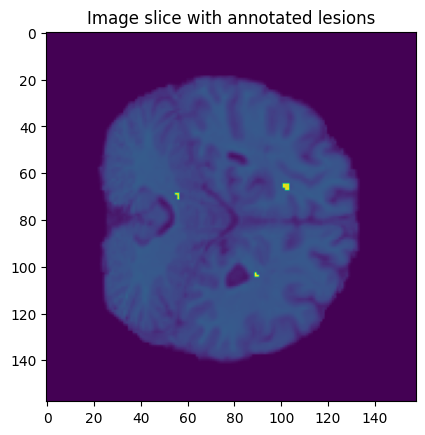

(232, 158, 158)


In [9]:
import os
from FilesHelpers.Nifti import Nifti

dataset_path = input("Input a path to dataset:") or r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/zenodo'

image = Nifti(os.path.join(dataset_path,"shifts_ms_pt1","shifts_ms_pt1","msseg","dev_in","t1","4_T1_isovox.nii"), os.path.join(dataset_path,"shifts_ms_pt1","shifts_ms_pt1","msseg","dev_in","gt","4_gt_isovox.nii"))

image.preview(slice_number=150, show_data_slice=True, show_annotation_slice=True)

Using NVIDIA GeForce RTX 3060 Ti device.
=> Loading state
(1, 1, 182, 182)


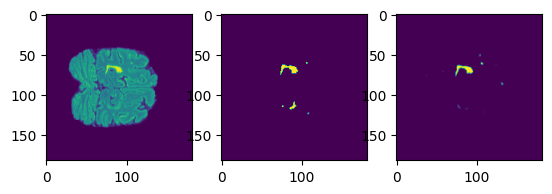

In [11]:
import torch
from Segmentation.model import UNet
from Segmentation.utils import load_state
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using {} device.".format(torch.cuda.get_device_name(device)))
model = UNet(initial_in_channels=1, initial_out_channels=1).to(device)

tar_file = torch.load(input("Path to file") or "results/18-11-2023_14-46/epoch_5.pth")
load_state(tar_file, model)

model.eval()

no  = input("The number of slice from dataset") or "4556"

img = np.expand_dims(np.load(r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/images/{}.npy'.format(no)), axis=0)
mask = np.expand_dims(np.load(r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/annotations/{}_mask.npy'.format(no)), axis=0)

print(img.shape)
mask_pred = torch.sigmoid(model(torch.from_numpy(img).float().to(device))).cpu().detach().numpy().squeeze(0).squeeze(0)

img = img.squeeze(0).squeeze(0)
mask = mask.squeeze(0).squeeze(0)
model.train()

fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(img)
axs[1].imshow(mask)
axs[2].imshow(mask_pred)
plt.show()

